# **Synthetic Data Generation Using CTGAN**


In [1]:
!pip install pandas numpy scikit-learn
!pip install sdv
!pip install ctgan

In [2]:
import torch

In [2]:
from ctgan import CTGAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('secondary_data_test2.csv')
print(data.info())  
print(data.isnull().sum())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           61069 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       61069 non-null  object 
 7   gill-spacing          61069 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

We drop features with more than 50% data missing.

In [ ]:
threshold = 0.5
data = data.loc[:, data.isnull().mean() < threshold]

We fill in the null values in the remaining categorical columns with the most frequent value for each column

In [ ]:
for column in data.select_dtypes(include=['object']):
    most_common = data[column].mode()[0]
    data[column].fillna(most_common, inplace=True)

We fill in null values in the remaining numerical columns with the mean value for each column

In [ ]:
for column in data.select_dtypes(include=[np.number]):
    data[column].fillna(data[column].mean(), inplace=True)

In [6]:
print(data.isnull().sum())  

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
continuous_columns = [col for col in train_data.columns if train_data[col].dtype != 'object']
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']

In [19]:
# Initialize CTGAN
ctgan = CTGAN(epochs=600, cuda=True if torch.cuda.is_available() else 'cpu')
ctgan.fit(train_data, discrete_columns=categorical_columns)

# Generate synthetic data
synthetic_data = ctgan.sample(len(train_data))

In [20]:
import pickle

with open('ctgan_model.pkl', 'wb') as file:
    pickle.dump(ctgan, file)


In [26]:
with open('ctgan_model.pkl', 'rb') as file:
    ctgan = pickle.load(file)

ctgan.fit(train_data, discrete_columns=categorical_columns)

In [27]:
synthetic_data = ctgan.sample(len(train_data))

In [ ]:
print(synthetic_data.head())

  class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     p      2.424508         x           t         y                    f   
1     e      5.681536         x           h         k                    f   
2     p      9.287534         x           k         w                    t   
3     p      3.190222         f           y         w                    f   
4     e      7.913740         x           t         n                    t   

  gill-attachment gill-spacing gill-color  stem-height  stem-width stem-color  \
0               a            c          w     6.238386    7.328249          y   
1               s            d          g     4.961383   12.308328          g   
2               d            c          p     7.560151   27.493103          w   
3               e            c          w    17.712096    2.598649          w   
4               p            c          p     9.109297   28.390635          w   

  has-ring ring-type habitat season  
0     

In [40]:
from ctgan import TVAE
tvae = TVAE(epochs=600, cuda=True if torch.cuda.is_available() else 'cpu')
tvae.fit(train_data, discrete_columns=categorical_columns)

In [41]:
synthetic_data2 = tvae.sample(len(train_data))

In [39]:
synthetic_data.to_csv('synthetic_data', index=False)

In [ ]:
ctgan.save('synthGenModel.pkl')

# **Synthetic Data Analysis and Comparison with Secondary Training data**

In [39]:
synthetic_data = pd.read_csv('synthetic_data_CTGANFinal.csv')
synthetic_data2 = pd.read_csv('synthetic_data2_TVAEFinal.csv')
train_data = pd.read_csv('train_data_Final.csv')

Class Distribution for Secondary Data:
class
p    0.554989
e    0.445011
Name: proportion, dtype: float64

Class Distribution for CTGAN Synthetic Data:
class
p    0.55546
e    0.44454
Name: proportion, dtype: float64

Class Distribution for TVAE Synthetic Data:
class
p    0.554191
e    0.445809
Name: proportion, dtype: float64


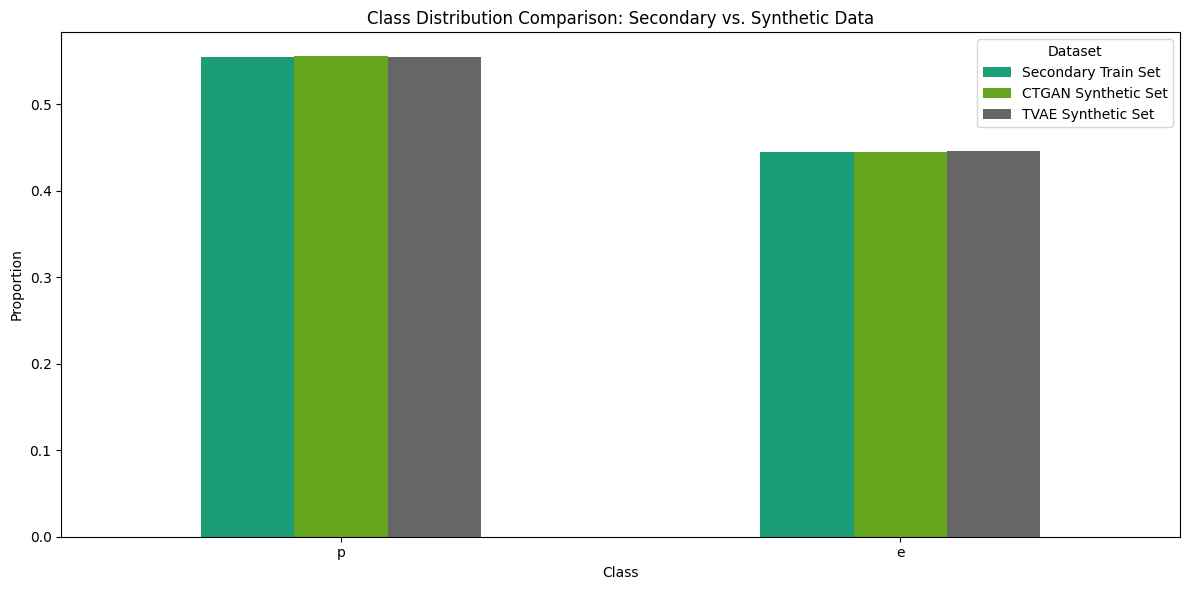

In [40]:
train_class_counts = train_data['class'].value_counts(normalize=True)  
ctgan_class_counts = synthetic_data['class'].value_counts(normalize=True)
tvae_class_counts = synthetic_data2['class'].value_counts(normalize=True)

print("Class Distribution for Secondary Data:")
print(train_class_counts)
print("\nClass Distribution for CTGAN Synthetic Data:")
print(ctgan_class_counts)
print("\nClass Distribution for TVAE Synthetic Data:")
print(tvae_class_counts)


comparison_df = pd.DataFrame({
    'Secondary Train Set': train_class_counts,
    'CTGAN Synthetic Set': ctgan_class_counts,
    'TVAE Synthetic Set': tvae_class_counts
}).fillna(0)  

ax = comparison_df.plot(kind='bar', figsize=(12, 6), colormap='Dark2')
plt.title('Class Distribution Comparison: Secondary vs. Synthetic Data')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.legend(title='Dataset')
plt.xticks(rotation=0)
plt.tight_layout()  
plt.show()

Original Paper mentions a correlation between Stem Height, Stem Width and Cap Diameter. Thus we evaluated correlation levels for each of our datasets.

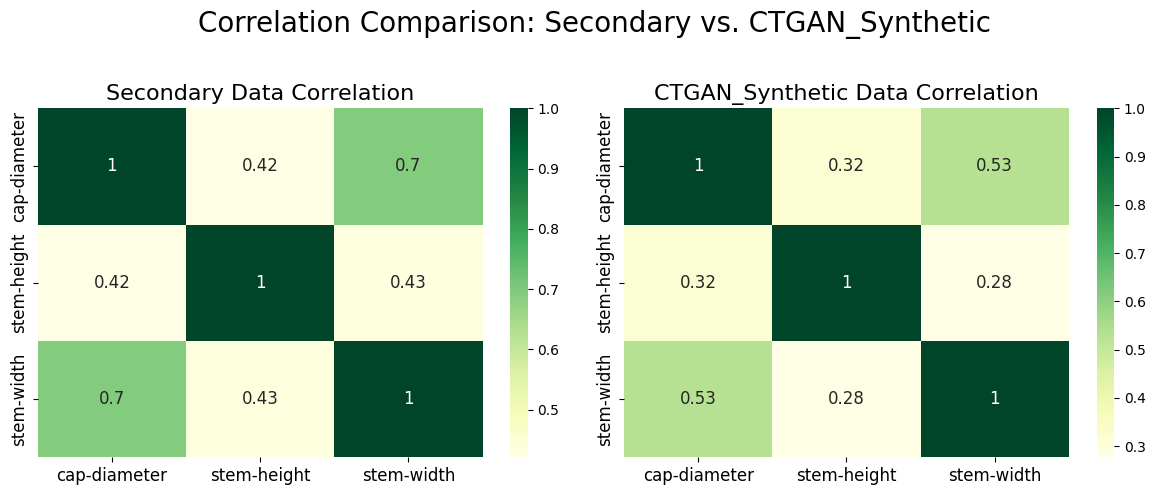

In [41]:
columns_of_interest = ['cap-diameter', 'stem-height', 'stem-width']
train_subset = train_data[columns_of_interest]
synthetic_subset = synthetic_data[columns_of_interest]

train_corr = train_subset.corr()
synthetic_corr = synthetic_subset.corr()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Correlation Comparison: Secondary vs. CTGAN_Synthetic', fontsize=20)  

sns.heatmap(train_corr, annot=True, cmap='YlGn', ax=axes[0], annot_kws={"size": 12})  
axes[0].set_title('Secondary Data Correlation', fontsize=16)  
axes[0].tick_params(axis='both', which='major', labelsize=12)  

sns.heatmap(synthetic_corr, annot=True, cmap='YlGn', ax=axes[1], annot_kws={"size": 12})  
axes[1].set_title('CTGAN_Synthetic Data Correlation', fontsize=16)  
axes[1].tick_params(axis='both', which='major', labelsize=12) 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


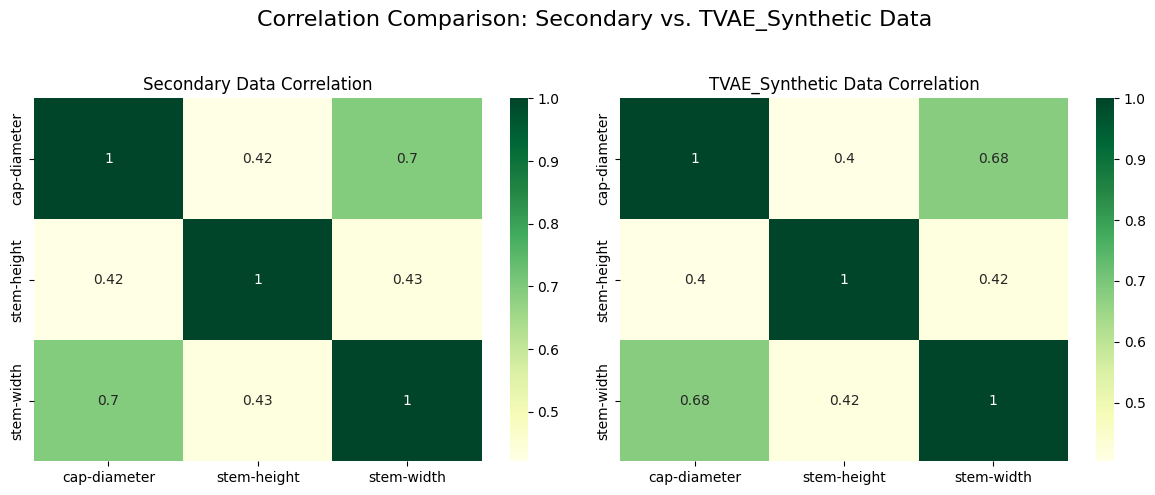

In [33]:
columns_of_interest = ['cap-diameter', 'stem-height', 'stem-width']
train_subset = train_data[columns_of_interest]
synthetic_subset = synthetic_data2[columns_of_interest]


train_corr = train_subset.corr()
synthetic_corr = synthetic_subset.corr()


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Correlation Comparison: Secondary vs. TVAE_Synthetic Data', fontsize=16)


sns.heatmap(train_corr, annot=True, cmap='YlGn', ax=axes[0], fontsize=16)
axes[0].set_title('Secondary Data Correlation')


sns.heatmap(synthetic_corr, annot=True, cmap='YlGn', ax=axes[1], fontsize=16)
axes[1].set_title('TVAE_Synthetic Data Correlation')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


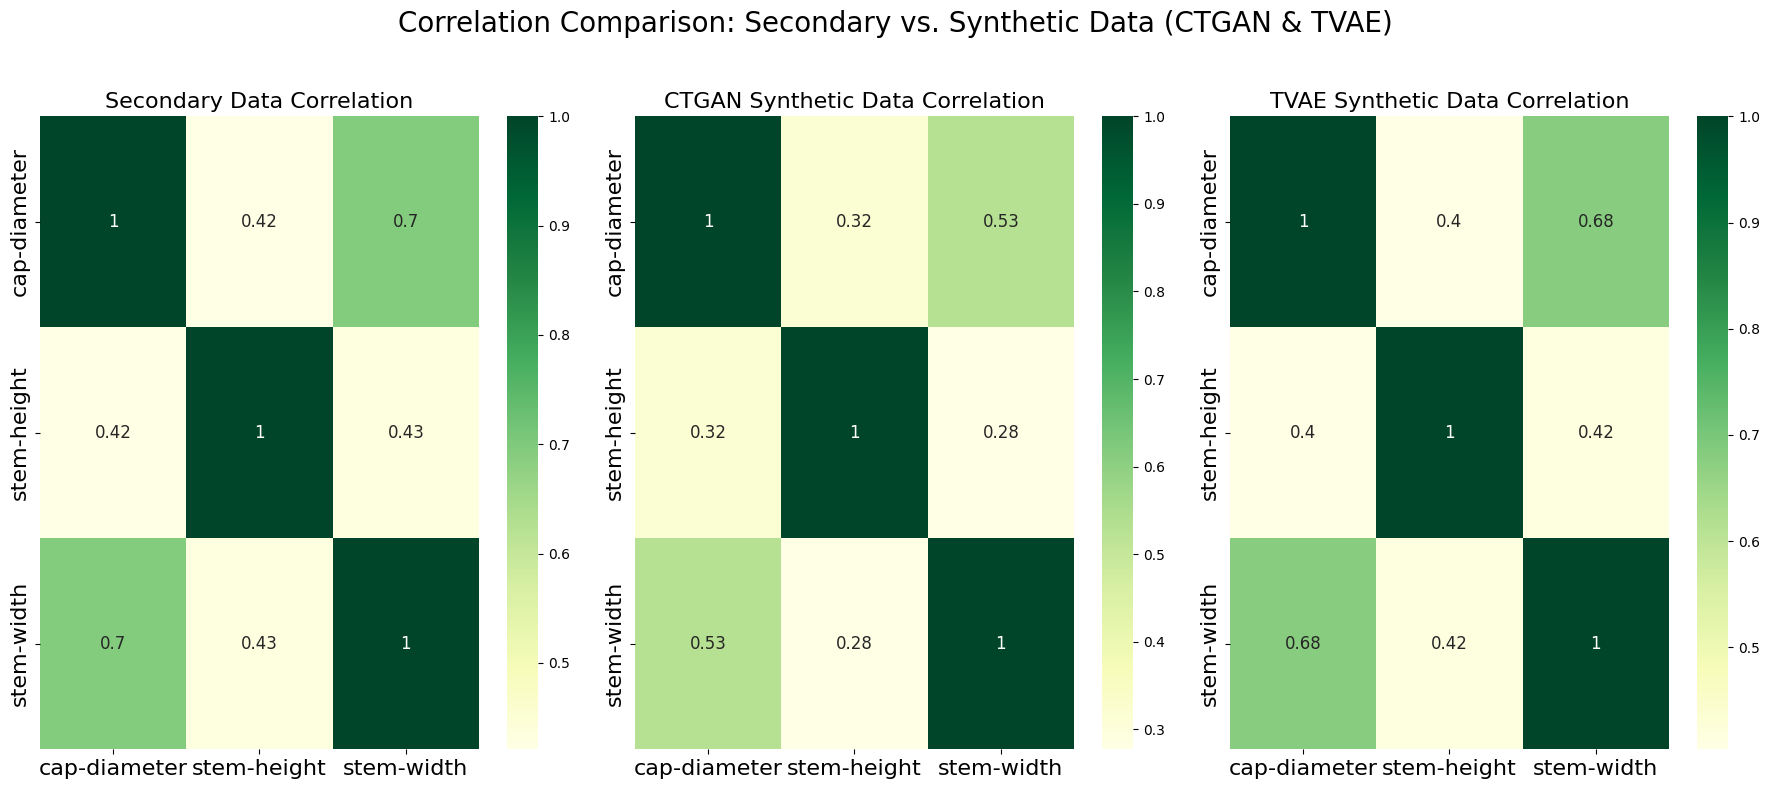

In [45]:
columns_of_interest = ['cap-diameter', 'stem-height', 'stem-width']

train_subset = train_data[columns_of_interest]
synthetic_subset_ctgan = synthetic_data[columns_of_interest]
synthetic_subset_tvae = synthetic_data2[columns_of_interest]


train_corr = train_subset.corr()
synthetic_corr_ctgan = synthetic_subset_ctgan.corr()
synthetic_corr_tvae = synthetic_subset_tvae.corr()

fig, axes = plt.subplots(1, 3, figsize=(18, 8)) 


fig.suptitle('Correlation Comparison: Secondary vs. Synthetic Data (CTGAN & TVAE)', fontsize=20)  


sns.heatmap(train_corr, annot=True, cmap='YlGn', ax=axes[0], annot_kws={"size": 12}) 
axes[0].set_title('Secondary Data Correlation', fontsize=16)  
axes[0].tick_params(axis='both', which='major', labelsize=16)  

sns.heatmap(synthetic_corr_ctgan, annot=True, cmap='YlGn', ax=axes[1], annot_kws={"size": 12})  
axes[1].set_title('CTGAN Synthetic Data Correlation', fontsize=16)  
axes[1].tick_params(axis='both', which='major', labelsize=16)  

sns.heatmap(synthetic_corr_tvae, annot=True, cmap='YlGn', ax=axes[2], annot_kws={"size": 12})  
axes[2].set_title('TVAE Synthetic Data Correlation', fontsize=16)  
axes[2].tick_params(axis='both', which='major', labelsize=16)  

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [47]:
synthetic_data.to_csv('synthetic_data_CTGANFinal.csv', index=False)
synthetic_data2.to_csv('synthetic_data2_TVAEFinal.csv', index=False)
train_data.to_csv('train_data_Final.csv', index=False)
test_data.to_csv('test_data_Final.csv', index=False)

In [48]:
with open('ctgan_final.pkl', 'wb') as file:
    pickle.dump(ctgan, file)
with open('tvae_final.pkl', 'wb') as file:
    pickle.dump(tvae, file)
